# A3: Make Your Own Machine Translation Language

**by Dechathon Niamsa-ard [st126235**]

### Import necessary libraries

This section loads all the core dependencies needed throughout the notebook. **PyTorch** serves as the deep learning framework for building and training the Transformer-based sequence-to-sequence model. **Pandas** handles loading and manipulating the parallel corpus CSV files. For tokenization, **spaCy** (`en_core_web_sm`) provides robust English tokenization - properly splitting punctuation and contractions - while **PyThaiNLP** handles Thai word segmentation, which is essential because Thai script does not use spaces between words. **Matplotlib** is used later for plotting training loss curves and attention heatmaps.

Since the original `torchtext` library has been deprecated and is incompatible with newer PyTorch versions (required for the Blackwell-architecture GPU), the key `torchtext` utilities - `build_vocab_from_iterator`, `Vocab`, and `get_tokenizer` - are re-implemented in a compatibility layer below to keep the pipeline working without any dependency on the deprecated package.

In [1]:
# pytorch core
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence  # for padding variable-length sequences in a batch
from torch.utils.data import DataLoader, Dataset  # standard data loading utilities

# data & numerical
import pandas as pd
import numpy as np

# standard library
import random
import math
import time
import re
import json

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Thai NLP - PyThaiNLP provides word segmentation for Thai (no spaces between words)
import pythainlp
from pythainlp.tokenize import word_tokenize as th_tokenize

# utilities for building vocabulary
from collections import Counter, OrderedDict
from functools import partial

# set up directory paths so I can reference files relative to the notebook location
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
MODEL_DIR = os.path.join(BASE_DIR, 'model')     # trained model checkpoints go here
ASSETS_DIR = os.path.join(BASE_DIR, 'assets')    # plots and images saved here
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(ASSETS_DIR, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Model Directory: {MODEL_DIR}")
print(f"Assets Directory: {ASSETS_DIR}")

# Note: The torchtext library is deprecated and has been removed from modern PyTorch distributions. 
# My GPU (Nvidia RTX 5060 Ti) utilizes the Blackwell architecture, which requires a recent version of PyTorch (likely 2.7+) to function. 
# Since torchtext is not compatible with these newer PyTorch versions, 
# I cannot run the original lab environment and must migrate the data loading pipeline to a supported method.

Base Directory: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language
Model Directory: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language\model
Assets Directory: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language\assets


In [2]:
_long_sp = os.path.join(
    os.path.dirname(os.path.abspath('__file__')),
    '.venv', 'Lib', 'site-packages'
)
_short_sp = r'C:\v\Lib\site-packages'
if os.path.isdir(_short_sp):
    # replace the long site-packages path with the short junction path
    sys.path = [_short_sp if p == _long_sp else p for p in sys.path]
    if _short_sp not in sys.path:
        sys.path.insert(0, _short_sp)
    # also register the short path for DLL loading (Python 3.8+)
    os.add_dll_directory(_short_sp)
    print(f"Long path fix applied: using {_short_sp}")
else:
    print("Note: C:\\v junction not found. If spaCy fails with DLL errors,")
    print("run in terminal:  cmd /c mklink /J C:\\v .venv")

Long path fix applied: using C:\v\Lib\site-packages


In [3]:
# ============================================================================
# Torchtext Compatibility Layer
# ============================================================================
# Pure-Python drop-in replacements for deprecated torchtext functions.
# Matches the original torchtext (v0.17) API as closely as possible:
#   - torchtext.data.utils.get_tokenizer
#   - torchtext.vocab.Vocab
#   - torchtext.vocab.build_vocab_from_iterator
# ============================================================================

from collections import Counter, OrderedDict
from functools import partial


# ---------------------------------------------------------------------------
# Tokenizer helpers (from torchtext/data/utils.py)
# ---------------------------------------------------------------------------

def _split_tokenizer(x):
    """Default tokenizer: split on whitespace."""
    return x.split()


def _spacy_tokenize(x, spacy):
    """Tokenize using a spaCy language model."""
    return [tok.text for tok in spacy.tokenizer(x)]


# Exact patterns / replacements from the original torchtext source
_patterns = [
    r"\'", r"\"", r"\.", r"<br \/>",
    r",", r"\(", r"\)", r"\!",
    r"\?", r"\;", r"\:", r"\s+",
]

_replacements = [
    " '  ", "", " . ", " ",
    " , ", " ( ", " ) ", " ! ",
    " ? ", " ", " ", " ",
]

_patterns_dict = list(
    (re.compile(p), r) for p, r in zip(_patterns, _replacements)
)


def _basic_english_normalize(line):
    r"""
    Basic normalization for a line of text.
    Normalization includes
    - lowercasing
    - complete some basic text normalization for English words as follows:
        add spaces before and after '\''
        remove '\"',
        add spaces before and after '.'
        replace '<br \/>' with single space
        add spaces before and after ','
        add spaces before and after '('
        add spaces before and after ')'
        add spaces before and after '!'
        add spaces before and after '?'
        replace ';' with single space
        replace ':' with single space
        replace multiple spaces with single space

    Returns a list of tokens after splitting on whitespace.
    """
    line = line.lower()
    for pattern_re, replaced_str in _patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()


# ---------------------------------------------------------------------------
# Vocab class (from torchtext/vocab/vocab.py)
# ---------------------------------------------------------------------------

class Vocab:
    r"""Pure-Python replacement for torchtext.vocab.Vocab.

    Maps tokens to indices. Provides the same public methods as the original:
        __len__, __contains__, __getitem__, forward,
        set_default_index, get_default_index,
        insert_token, append_token,
        lookup_token, lookup_tokens, lookup_indices,
        get_stoi, get_itos
    """

    def __init__(self, tokens, default_index=None):
        """
        Args:
            tokens: ordered list of unique token strings.
            default_index: index returned for OOV tokens (None = raise).
        """
        self._itos = list(tokens)
        self._stoi = {tok: i for i, tok in enumerate(self._itos)}
        self._default_index = default_index

    # --- sizes / membership ------------------------------------------------

    def __len__(self):
        return len(self._itos)

    def __contains__(self, token):
        return token in self._stoi

    # --- index lookup ------------------------------------------------------

    def __getitem__(self, token):
        if self._default_index is not None:
            return self._stoi.get(token, self._default_index)
        if token not in self._stoi:
            raise RuntimeError(
                f"Token '{token}' not found and default index is not set"
            )
        return self._stoi[token]

    def forward(self, tokens):
        """Calls lookup_indices (same as original torchtext)."""
        return self.lookup_indices(tokens)

    # --- default index -----------------------------------------------------

    def set_default_index(self, index):
        self._default_index = index

    def get_default_index(self):
        return self._default_index

    # --- mutation ----------------------------------------------------------

    def insert_token(self, token, index):
        """Insert *token* at *index*, shifting later tokens right."""
        if token in self._stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        if index < 0 or index > len(self._itos):
            raise RuntimeError(
                f"Index {index} is not in range [0, {len(self._itos)}]"
            )
        # Shift existing tokens at >= index
        for t, i in self._stoi.items():
            if i >= index:
                self._stoi[t] = i + 1
        self._stoi[token] = index
        self._itos.insert(index, token)

    def append_token(self, token):
        """Append *token* at the end of the vocab."""
        if token in self._stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self._stoi[token] = len(self._itos)
        self._itos.append(token)

    # --- lookup helpers ----------------------------------------------------

    def lookup_token(self, index):
        """Return the token at *index*."""
        if index < 0 or index >= len(self._itos):
            raise RuntimeError(
                f"Index {index} not in range [0, {len(self._itos)})"
            )
        return self._itos[index]

    def lookup_tokens(self, indices):
        """Return tokens for a list of indices."""
        return [self.lookup_token(i) for i in indices]

    def lookup_indices(self, tokens):
        """Return indices for a list of tokens."""
        return [self[t] for t in tokens]

    # --- export ------------------------------------------------------------

    def get_stoi(self):
        """Return dict mapping tokens -> indices."""
        return dict(self._stoi)

    def get_itos(self):
        """Return list mapping indices -> tokens."""
        return list(self._itos)


# ---------------------------------------------------------------------------
# vocab() factory  (from torchtext/vocab/vocab_factory.py)
# ---------------------------------------------------------------------------

def _vocab_factory(ordered_dict, min_freq=1, specials=None, special_first=True):
    """Factory that builds a Vocab from an OrderedDict of {token: freq}."""
    specials = specials or []
    for token in specials:
        ordered_dict.pop(token, None)

    tokens = []
    for token, freq in ordered_dict.items():
        if freq >= min_freq:
            tokens.append(token)

    if special_first:
        tokens[0:0] = specials          # prepend specials
    else:
        tokens.extend(specials)         # append specials

    return Vocab(tokens)


# ---------------------------------------------------------------------------
# build_vocab_from_iterator  (from torchtext/vocab/vocab_factory.py)
# ---------------------------------------------------------------------------

def build_vocab_from_iterator(iterator, min_freq=1, specials=None,
                              special_first=True, max_tokens=None):
    """Build a Vocab from an iterator that yields lists of tokens.

    Args:
        iterator:      yields lists (or iterators) of tokens.
        min_freq:      minimum frequency to include a token.
        specials:      special symbols to add (e.g. ['<unk>', '<pad>']).
        special_first: put specials at the beginning (True) or end (False).
        max_tokens:    cap the vocab size (excluding specials).
    """
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    specials = specials or []

    # Sort by descending frequency, then lexicographically (original behaviour)
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    if max_tokens is None:
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
    else:
        assert len(specials) < max_tokens, \
            "len(specials) >= max_tokens, so the vocab will be entirely special tokens."
        ordered_dict = OrderedDict(sorted_by_freq_tuples[: max_tokens - len(specials)])

    return _vocab_factory(ordered_dict, min_freq=min_freq,
                          specials=specials, special_first=special_first)


# ---------------------------------------------------------------------------
# get_tokenizer  (from torchtext/data/utils.py)
# ---------------------------------------------------------------------------

def get_tokenizer(tokenizer, language="en"):
    r"""Generate tokenizer function for a string sentence.

    Args:
        tokenizer: the name of tokenizer function. If None, it returns split()
            function, which splits the string sentence by space.
            If basic_english, it returns _basic_english_normalize() function,
            which normalize the string first and split by space. If a callable
            function, it will return the function. If a tokenizer library
            (e.g. spacy, moses, toktok, revtok, subword), it returns the
            corresponding library.
        language: Default en
    """
    # Default tokenizer is string.split()
    if tokenizer is None:
        return _split_tokenizer

    if tokenizer == "basic_english":
        if language != "en":
            raise ValueError("Basic normalization is only available for English(en)")
        return _basic_english_normalize

    # If a callable is passed, return it directly
    if callable(tokenizer):
        return tokenizer

    if tokenizer == "spacy":
        try:
            import spacy as spacy_lib
            spacy_model = spacy_lib.load(language)
            return partial(_spacy_tokenize, spacy=spacy_model)
        except ImportError:
            print("Please install SpaCy. See the docs at https://spacy.io for more information.")
            raise

    elif tokenizer == "moses":
        try:
            from sacremoses import MosesTokenizer
            moses_tokenizer = MosesTokenizer()
            return moses_tokenizer.tokenize
        except ImportError:
            print("Please install SacreMoses. See the docs at https://github.com/alvations/sacremoses for more information.")
            raise

    elif tokenizer == "toktok":
        try:
            from nltk.tokenize.toktok import ToktokTokenizer
            toktok = ToktokTokenizer()
            return toktok.tokenize
        except ImportError:
            print("Please install NLTK. See the docs at https://nltk.org for more information.")
            raise

    elif tokenizer == "revtok":
        try:
            import revtok
            return revtok.tokenize
        except ImportError:
            print("Please install revtok.")
            raise

    elif tokenizer == "subword":
        try:
            import revtok
            return partial(revtok.tokenize, decap=True)
        except ImportError:
            print("Please install revtok.")
            raise

    raise ValueError(
        "Requested tokenizer {}, valid choices are a "
        "callable that takes a single string as input, "
        '"revtok" for the revtok reversible tokenizer, '
        '"subword" for the revtok caps-aware tokenizer, '
        '"spacy" for the SpaCy English tokenizer, or '
        '"moses" for the NLTK port of the Moses tokenization '
        "script.".format(tokenizer)
    )


# ---------------------------------------------------------------------------
# Torchtext-compatible namespace (so `torchtext.data.utils.get_tokenizer` etc. works)
# ---------------------------------------------------------------------------

class torchtext:
    """Compatibility namespace mirroring the real torchtext package."""
    class data:
        class utils:
            get_tokenizer = staticmethod(get_tokenizer)
    class vocab:
        Vocab = Vocab
        build_vocab_from_iterator = staticmethod(build_vocab_from_iterator)

print("Torchtext compatibility layer loaded successfully!")
print("Available: get_tokenizer, build_vocab_from_iterator, Vocab")

Torchtext compatibility layer loaded successfully!
Available: get_tokenizer, build_vocab_from_iterator, Vocab


In [4]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version used by PyTorch: {torch.version.cuda}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
print(f'Using device: {device}')

PyTorch Version: 2.10.0+cu130
CUDA Version used by PyTorch: 13.0
GPU Name: NVIDIA GeForce RTX 5060 Ti
GPU Capability: (12, 0)
Using device: cuda


In [5]:
# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1. Get Language Pair
- Based on MT + Transformer.ipynb, modify the dataset as follows:
1) Find a dataset suitable for translation between your native language and English. Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation. (1 points)
2) Describe in detail the process of preparing the dataset for use in your translation model. This
includes steps like text normalization, tokenization, and word segmentation, particularly focusing
on your native language’s specific requirements. Specify the libraries or tools you will use for these
tasks and give appropriate credit to the developers or organizations behind these tools. If your
native language requires special handling in tokenization (e.g., for languages like Chinese, Thai, or
Japanese), mention the libraries (like Jieba, PyThaiNLP, or Mecab) and the procedures used for
word segmentation. (1 points)

**Note:** proper attribution for both the dataset and the tools used in its processing is essential for main
taining academic integrity.

### Load and Clean the Dataset
Dataset Name: SCB-MT-EN-TH-2020

Source: AI Research Institute of Thailand (AIRESEARCH)

URL: https://airesearch.in.th/releases/machine-translation-datasets/

The **SCB-MT-EN-TH-2020** dataset is a large-scale English-Thai parallel corpus released by the AI Research Institute of Thailand (AIRESEARCH). The `generated_reviews_crowd.csv` subset is used here, containing approximately 10,000 crowd-sourced parallel sentence pairs with natural, conversational text - making it well-suited for training a neural translation model. Each row contains an `en_text` column (English) and a `th_text` column (Thai), representing aligned translation pairs.

Basic cleaning is applied: rows with missing values are dropped, and duplicate sentence pairs are removed to prevent data leakage and biased training. This ensures the model learns from unique, high-quality examples only.

In [6]:
# Load the scb_mt_enth_2020 dataset (subdataset: generated_reviews_crowd.csv)
# This file has ~10k parallel sentence pairs with columns: en_text, th_text
csv_path = os.path.join(BASE_DIR, 'dataset', 'scb-mt-en-th-2020', 'generated_reviews_crowd.csv')
df = pd.read_csv(csv_path)
print(f"Raw dataset size: {len(df)} rows")
print(df.head())

# Drop rows where either the English or Thai text is missing (NaN)
df = df.dropna(subset=['en_text', 'th_text']).reset_index(drop=True)

# Strip leading/trailing whitespace and collapse multiple spaces into one
df['en_text'] = df['en_text'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
df['th_text'] = df['th_text'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

# Filter out sentences that are too long (>100 English words) or too short (<2 English words)
# Very long sentences slow down training and often contain noisy data
# Very short sentences (single words) don't provide enough context for the model to learn from
df = df[df['en_text'].str.split().str.len().between(2, 100)]
# For Thai, I check character length since Thai doesn't use spaces between words
df = df[df['th_text'].str.len() > 2]
df = df.reset_index(drop=True)

print(f"Cleaned dataset size: {len(df)} rows")
print(f"\nSample pair:")
print(f"  EN: {df.loc[0, 'en_text']}")
print(f"  TH: {df.loc[0, 'th_text']}")

Raw dataset size: 24587 rows
                                             en_text  \
0                        Doesn't snap together well.   
1  Charged it after every use as directed for abo...   
2  My son wanted this movie so badly, that he sai...   
3    But his writing has degenerated in later books.   
4  It was supposed to be a good bag, well you get...   

                                             th_text  
0                                   เข้ากันไม่ค่อยดี  
1  เรียกเก็บเงินหลังจากใช้งานทุกครั้งตามที่กำกับไ...  
2  ลูกชายของฉันต้องการภาพยนตร์เรื่องนี้เพื่อไม่ดี...  
3     แต่หนังสือเล่มที่ผ่านมาของเขามันดูด้อยคุณภาพลง  
4  มันควรที่จะเป็นกระเป๋าที่ดี เอ้อ เธอได้ในสิ่งท...  
Cleaned dataset size: 24587 rows

Sample pair:
  EN: Doesn't snap together well.
  TH: เข้ากันไม่ค่อยดี


### Create Train/ Validation/ Test Splits

The dataset is divided into three non-overlapping subsets using an **80/10/10** ratio:
- **Training set (80%)** - used to update the model weights through backpropagation.
- **Validation set (10%)** - monitored during training to detect overfitting and select the best model checkpoint.
- **Test set (10%)** - held out entirely until after training for a final, unbiased evaluation.

The data is shuffled before splitting (with a fixed random seed for reproducibility) to ensure each split has a roughly equal distribution of sentence types and lengths. HuggingFace's `DatasetDict` provides a convenient container that allows accessing each split by name (e.g., `dataset['train']`).

In [7]:
# I split the data into train/val/test with an 80/10/10 ratio.
# Use HuggingFace's DatasetDict to keep things organized - it's a convenient
# Container that lets me access splits like dataset['train'], dataset['validation'], etc.
from datasets import Dataset, DatasetDict

# Shuffle the dataframe so the model doesn't learn any ordering artifacts
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Calculate split boundaries
n = len(df)
train_end = int(0.8 * n)   # first 80% for training
val_end = int(0.9 * n)     # next 10% for validation

train_df = df[:train_end]
val_df = df[train_end:val_end]
test_df = df[val_end:]      # last 10% for testing

# Wrap each split into a HuggingFace Dataset, then combine into a DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'validation': Dataset.from_pandas(val_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
})

print(dataset)
print(f"\nTrain: {len(dataset['train'])} | Val: {len(dataset['validation'])} | Test: {len(dataset['test'])}")

DatasetDict({
    train: Dataset({
        features: ['en_text', 'th_text'],
        num_rows: 19669
    })
    validation: Dataset({
        features: ['en_text', 'th_text'],
        num_rows: 2459
    })
    test: Dataset({
        features: ['en_text', 'th_text'],
        num_rows: 2459
    })
})

Train: 19669 | Val: 2459 | Test: 2459


### Tokenization

Tokenization is a critical preprocessing step that converts raw text into sequences of discrete tokens that the model can process. Two different tokenization strategies are needed because English and Thai have fundamentally different writing systems:

- **English** - spaCy's `en_core_web_sm` model handles punctuation separation, contractions (e.g., "don't" → "do", "n't"), and produces clean, linguistically-informed token lists.
- **Thai** - Thai script is written continuously **without spaces between words**, so a specialized word segmentation tool is required. **PyThaiNLP**'s `newmm` (New Maximum Matching) engine uses a dictionary-based approach to identify word boundaries and segment Thai text into meaningful word units.

This two-language tokenization approach ensures both the source and target languages are properly tokenized according to their specific linguistic requirements, as emphasized in the assignment guidelines.

**Note**: the spaCy model must first be downloaded using the following on the command line:
```bash
python3 -m spacy download en_core_web_sm
```

In [8]:
# Define source and target language codes - I'm translating English to Thai
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

# Dictionaries to hold the tokenizer functions and vocabs for each language
token_transform = {}
vocab_transform = {}

# English tokenizer - I use spaCy's en_core_web_sm model which handles
# Punctuation separation, contractions, and produces clean token lists.
# The get_tokenizer function from my torchtext compat layer loads spaCy internally.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Thai tokenizer - since Thai script doesn't use spaces between words,
# I need a specialized word segmentation tool. PyThaiNLP's newmm engine
# uses maximum matching with a Thai dictionary to split text into words.
def thai_tokenizer(text):
    return th_tokenize(text, engine='newmm')

token_transform[TRG_LANGUAGE] = thai_tokenizer

# Quick test to verify both tokenizers work correctly
sample_en = dataset['train'][0]['en_text']
sample_th = dataset['train'][0]['th_text']
print(f"EN: {sample_en}")
print(f"EN tokens: {token_transform[SRC_LANGUAGE](sample_en)}")
print(f"\nTH: {sample_th}")
print(f"TH tokens: {token_transform[TRG_LANGUAGE](sample_th)}")

EN: What I received was not what you send if ordered.
EN tokens: ['What', 'I', 'received', 'was', 'not', 'what', 'you', 'send', 'if', 'ordered', '.']

TH: สิ่งที่ได้รับไม่ใช่ที่คุณส่งตามคำสั่งซื้อ
TH tokens: ['สิ่ง', 'ที่', 'ได้รับ', 'ไม่', 'ใช่', 'ที่', 'คุณ', 'ส่ง', 'ตามคำสั่ง', 'ซื้อ']


### Build Vocabulary

The vocabulary maps each unique token to an integer index that the neural network can process numerically. Four **special tokens** are defined with fixed indices:
| Token | Index | Purpose |
|-------|-------|---------|
| `<unk>` | 0 | Unknown/out-of-vocabulary words |
| `<pad>` | 1 | Padding shorter sequences to equal length |
| `<sos>` | 2 | Start-of-sequence signal for the decoder |
| `<eos>` | 3 | End-of-sequence signal to stop generation |

Vocabularies are built **exclusively from the training set** to prevent data leakage - the model should never see validation or test tokens during vocabulary construction. A minimum frequency threshold (`min_freq=2`) filters out tokens that appear only once, which are typically typos or noise. This keeps the vocabulary compact and improves the model's ability to generalize.

In [9]:
# Special tokens and their fixed indices - these are standard in seq2seq models:
# <unk> = 0: unknown token (for words not in vocabulary)
# <pad> = 1: padding token (to make all sequences in a batch the same length)
# <sos> = 2: start-of-sequence (tells the decoder to begin generating)
# <eos> = 3: end-of-sequence (tells the decoder to stop generating)
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Generator that yields tokenized sentences from the dataset one at a time
# build_vocab_from_iterator consumes this lazily so I don't have to load everything into memory
def yield_tokens(data_split, language):
    lang_col = 'en_text' if language == SRC_LANGUAGE else 'th_text'
    for example in data_split:
        yield token_transform[language](example[lang_col])

# Build vocab from training set only (never from val/test to avoid data leakage)
# min_freq=2 means I skip tokens that appear only once - they're usually typos or noise
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(dataset['train'], ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True   # Special tokens get the lowest indices (0, 1, 2, 3)
    )

# Set default index to UNK so any out-of-vocabulary word maps to index 0 instead of crashing
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

print(f"English vocab size: {len(vocab_transform[SRC_LANGUAGE])}")
print(f"Thai vocab size: {len(vocab_transform[TRG_LANGUAGE])}")

# Sanity check - 'hello' and 'world' should have real indices, 'unknownXYZ' should map to 0 (UNK)
print(f"\nEN lookup: {vocab_transform[SRC_LANGUAGE].lookup_indices(['hello', 'world', 'unknownXYZ'])}")
print(f"TH lookup: {vocab_transform[TRG_LANGUAGE].lookup_indices(['สวัสดี', 'ครับ', 'unknownXYZ'])}")

English vocab size: 6531
Thai vocab size: 6136

EN lookup: [0, 701, 0]
TH lookup: [0, 2198, 0]


### Prepare DataLoaders

The DataLoader pipeline transforms raw text pairs into padded, numericalized tensors ready for the model. For each language, the pipeline follows three sequential steps:

1. **Tokenize** - split raw text into tokens using the language-specific tokenizer (spaCy or PyThaiNLP).
2. **Numericalize** - convert each token to its vocabulary index using `lookup_indices`.
3. **Wrap with special tokens** - prepend `<sos>` and append `<eos>` to mark sequence boundaries.

A custom **collate function** assembles individual samples into batches by padding shorter sequences with `<pad>` tokens so all sequences have the same length within a batch. Sequences exceeding `MAX_SEQ_LEN` (512 tokens) are truncated to prevent index-out-of-bounds errors in the positional embedding layer (which only has that many entries). The training DataLoader shuffles the data each epoch for better generalization, while validation and test loaders maintain a fixed order.

In [10]:
# Batch size of 64 works well for my GPU memory - large enough for stable gradients,
# Small enough to not run out of VRAM on the RTX 5060 Ti (16 GB)
BATCH_SIZE = 64

# Maximum sequence length (including SOS/EOS tokens) - any sequence longer than this
# Gets truncated. This MUST match the max_length used in the Encoder/Decoder positional
# Embeddings, otherwise we get a CUDA "device-side assert" error when pos indices exceed
# The embedding table size. I set it to 512 which is generous for this dataset.
MAX_SEQ_LEN = 512

# Utility to chain multiple transforms together into a single callable pipeline
# e.g., sequential_transforms(tokenize, numericalize, add_sos_eos) creates one function
# That does all three steps in order when called on a raw text string
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Wraps a list of token indices with SOS at the start and EOS at the end,
# Then converts to a PyTorch tensor. This is what the model actually consumes.
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# Build the full transform pipeline for each language:
# raw text -> tokenize -> convert tokens to integer indices -> wrap with SOS/EOS
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln],                    # step 1: split text into tokens
        vocab_transform[ln].lookup_indices,     # step 2: convert tokens to vocab indices
        tensor_transform                        # step 3: add SOS/EOS and make tensor
    )

# Simple PyTorch Dataset wrapper around the HuggingFace dataset
# __getitem__ returns a raw (en_text, th_text) string pair
# Note: I use self._dataset instead of self.data because PyTorch's Dataset
# Base class already defines a 'data' property, which causes an AttributeError.
# I also set __getitems__ = None so PyTorch's DataLoader doesn't try to use
# HuggingFace's batch-fetching, which returns dicts instead of our tuples.
class TranslationDataset(Dataset):
    __getitems__ = None

    def __init__(self, hf_dataset):
        self._dataset = hf_dataset

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        item = self._dataset[idx]
        return item['en_text'], item['th_text']

# Collate function - called by the DataLoader to assemble individual samples into a batch
# It applies the text transforms to each sample, then pads all sequences to the same length.
# IMPORTANT: I truncate any sequence longer than MAX_SEQ_LEN to prevent index-out-of-bounds
# Errors in the positional embedding layer (which only has MAX_SEQ_LEN entries).
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        # apply the full pipeline: tokenize + numericalize + SOS/EOS
        processed_src = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        processed_trg = text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n"))
        # truncate sequences that exceed the positional embedding limit
        if processed_src.size(0) > MAX_SEQ_LEN:
            processed_src = processed_src[:MAX_SEQ_LEN]
        if processed_trg.size(0) > MAX_SEQ_LEN:
            processed_trg = processed_trg[:MAX_SEQ_LEN]
        src_batch.append(processed_src)
        trg_batch.append(processed_trg)
        # I keep track of the original source length before padding (useful for packing later)
        src_len_batch.append(processed_src.size(0))
    # pad_sequence pads shorter sequences with PAD_IDX so they all have the same length
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

# Create dataset objects for each split
train_dataset = TranslationDataset(dataset['train'])
val_dataset = TranslationDataset(dataset['validation'])
test_dataset = TranslationDataset(dataset['test'])

# Create DataLoaders - shuffle training data each epoch for better generalization
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# Verify shapes - I expect [batch_size, seq_len] for both source and target
for en, en_len, th in train_loader:
    print(f"Source (EN) batch shape: {en.shape}")
    print(f"Target (TH) batch shape: {th.shape}")
    break

Source (EN) batch shape: torch.Size([64, 51])
Target (TH) batch shape: torch.Size([64, 44])


## Task 2. Experiment with Attention Mechanisms
- Implementasequence-to-sequence neural network
for the translation task. Your implementation should include the following attention mechanisms, with
their respective equations:
1) General Attention: (0.5 points)
$$e_i = s^T h_i \in \mathbb{R} \quad \text{where} \quad d_1 = d_2$$
2) Additive Attention: (0.5 points)
$$e_i = v^t \tanh(\mathbf{W}_1 h_i + \mathbf{W}_2 s) \in \mathbb{R}$$

**Note:** For an in-depth exploration of attention mechanisms, you can refer to this paper.

An Attentive Survey of Attention Models https://arxiv.org/pdf/1904.02874.pdf

### Design the model

The translation model follows the **Transformer architecture** introduced in *"Attention Is All You Need"* (Vaswani et al., 2017). It consists of an **Encoder** that processes the source English sentence into a sequence of contextualized representations, and a **Decoder** that generates the target Thai translation one token at a time, conditioned on both the encoder output and the previously generated tokens.

The key experiment here is **swapping the attention mechanism** used inside both the encoder and decoder layers. Two variants are implemented - **General Attention** (scaled dot-product) and **Additive Attention** (Bahdanau-style) - while keeping all other hyperparameters identical. This controlled setup allows a fair comparison of how the choice of attention mechanism affects translation quality.

#### Multi Head Attention Layer

Multi-head attention is the core building block of the Transformer. Instead of computing a single attention function over the full embedding dimension, the representation is split into multiple **heads**, each operating on a smaller subspace. This allows the model to jointly attend to information from **different representation subspaces** at different positions - for example, one head might capture syntactic relationships while another captures semantic similarity.

Each head independently computes attention over queries (Q), keys (K), and values (V) through learned linear projections. The outputs from all heads are concatenated and passed through a final linear layer to produce the result. This implementation uses the standard **scaled dot-product** attention formula by default.

In [11]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

#### General Attention Layer

General Attention computes alignment scores using the **dot product** between query and key vectors:

$$e_i = s^T h_i \in \mathbb{R} \quad \text{where} \quad d_1 = d_2$$

In the multi-head setting, this is scaled by $\sqrt{d_k}$ (the dimension per head) to prevent the dot products from growing too large - which would push the softmax into regions with extremely small gradients. This mechanism is computationally efficient because it relies purely on matrix multiplication, making it highly parallelizable and fast on modern GPUs. The resulting attention weights are applied to the value vectors to produce a weighted representation of the source sequence, effectively allowing each position to "focus" on the most relevant parts of the input.

In [12]:
class GeneralAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        # make sure hidden dimension is evenly divisible by number of heads
        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads  # each head operates on this many dimensions

        # linear projections for Query, Key, Value, and Output
        # these transform the input into the multi-head format
        self.fc_q = nn.Linear(hid_dim, hid_dim)  # query projection
        self.fc_k = nn.Linear(hid_dim, hid_dim)  # key projection
        self.fc_v = nn.Linear(hid_dim, hid_dim)  # value projection
        self.fc_o = nn.Linear(hid_dim, hid_dim)  # output projection (after concatenating heads)

        self.dropout = nn.Dropout(dropout)
        # pre-compute the scaling factor and move to device
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        # query/key/value shape: [batch_size, seq_len, hid_dim]
        batch_size = query.shape[0]

        # project inputs through learned linear layers
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # reshape into multi-head format: [batch, n_heads, seq_len, head_dim]
        # permute swaps the seq_len and n_heads dimensions so each head processes independently
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # core of scaled dot-product attention:
        # energy[i][j] = how much token i should attend to token j
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy shape: [batch, n_heads, query_len, key_len]

        # mask out padding positions so the model doesn't attend to <pad> tokens
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # softmax converts raw scores to probabilities that sum to 1 along the key dimension
        attention = torch.softmax(energy, dim=-1)

        # weighted sum: multiply attention weights by values to get the attended output
        x = torch.matmul(self.dropout(attention), V)
        # reshape back: [batch, seq_len, hid_dim] by concatenating all heads
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        # final linear projection to mix information across heads
        x = self.fc_o(x)

        return x, attention

#### Additive Attention Layer

Additive Attention (also known as **Bahdanau attention**) computes alignment scores using a small feedforward network:

$$e_i = v^T \tanh(W_1 h_i + W_2 s) \in \mathbb{R}$$

Here, $W_1$ and $W_2$ are learned weight matrices that project the key ($h_i$) and query ($s$) into a shared space, `tanh` introduces non-linearity, and $v$ is a learned vector that collapses the result into a scalar attention score. Compared to General Attention, Additive Attention has **more learnable parameters** (the additional $W_1$, $W_2$, and $v$ matrices) and is theoretically more expressive since it can learn **non-linear relationships** between queries and keys. The trade-off is slightly higher computational cost due to the element-wise operations and the extra matrix multiplications.

In [13]:
class AdditiveAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        # same Q/K/V/O projections as General attention
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # the additive attention parameters - these are the "small feedforward network"
        # W1 projects the key, W2 projects the query, and v collapses the result to a scalar
        self.W1 = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.W2 = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.v = nn.Linear(self.head_dim, 1, bias=False)  # produces a single attention score

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        # project and reshape - same as General attention
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        q_len = Q.shape[2]
        k_len = K.shape[2]

        # expand Q and K so I can compute a score for every (query_pos, key_pos) pair
        # Q_expanded: [batch, n_heads, q_len, 1, head_dim] - broadcast over key positions
        # K_expanded: [batch, n_heads, 1, k_len, head_dim] - broadcast over query positions
        Q_expanded = Q.unsqueeze(3)
        K_expanded = K.unsqueeze(2)

        # the Bahdanau formula: v^T * tanh(W1 @ K + W2 @ Q)
        # tanh squashes values to [-1, 1], then v projects to a scalar score
        energy = self.v(torch.tanh(self.W1(K_expanded) + self.W2(Q_expanded))).squeeze(-1)
        # energy shape: [batch, n_heads, q_len, k_len]

        # mask padding positions (same as General attention)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # softmax to get attention probabilities
        attention = torch.softmax(energy, dim=-1)

        # weighted sum with values, then reshape and project
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention

#### Position-wise Feedforward Layer

The position-wise feedforward network (FFN) is applied **independently to each position** in the sequence. It consists of two linear transformations with a ReLU activation in between:

$$\text{FFN}(x) = W_2 \cdot \text{ReLU}(W_1 x + b_1) + b_2$$

The first layer expands the dimensionality from `hid_dim` to `pf_dim` (a larger intermediate size), and the second projects it back down. This expansion-compression pattern allows the network to learn richer, more complex representations at each position while keeping the output dimension consistent with the rest of the model. Dropout is applied after the ReLU to regularize the expanded representation.

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

#### Encoder Layer

Each encoder layer contains two sub-layers connected with **residual connections** and **layer normalization**:

1. **Multi-head self-attention** - every position in the source sequence attends to every other position, enabling the model to capture long-range dependencies (e.g., a pronoun referring to a noun several words earlier).
2. **Position-wise feedforward network** - applies a non-linear transformation independently at each position.

The residual connections ($x + \text{sublayer}(x)$) help gradients flow through deep networks during backpropagation, while layer normalization stabilizes activations and accelerates training convergence. The attention mechanism used here is interchangeable - either `GeneralAttentionLayer` or `AdditiveAttentionLayer` - depending on the experiment configuration.

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_class):
        super().__init__()
        # layer norms for each sub-layer (applied after residual addition)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        # the attention mechanism - either GeneralAttentionLayer or AdditiveAttentionLayer
        self.self_attention = attention_class(hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # sub-layer 1: self-attention with residual connection
        # the input attends to itself - every source position looks at every other position
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # sub-layer 2: feedforward with residual connection
        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

#### Encoder

The Encoder stacks multiple identical encoder layers to build progressively more abstract representations of the source sequence. The input tokens first pass through a **token embedding** layer (mapping each vocabulary index to a dense vector), then are combined with **learned positional embeddings** that encode each token's position in the sequence - since the Transformer has no recurrence, positional information must be explicitly injected.

The token embeddings are scaled by $\sqrt{d_{model}}$ (following the original Transformer paper) to prevent the positional embeddings from dominating. A **source mask** ensures that padding tokens (`<pad>`) are ignored during attention computation, so the model does not learn spurious patterns from padding positions.

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_class, max_length=100):
        super().__init__()
        self.device = device
        # token embedding: maps each vocab index to a dense vector of size hid_dim
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # positional embedding: learned position encodings (up to max_length positions)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        # stack of N identical encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention_class)
            for _ in range(n_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        # scaling factor from the original paper - prevents embeddings from being too small
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        # create position indices [0, 1, 2, ..., src_len-1] for each item in the batch
        #pos: [batch_size, src_len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # combine scaled token embeddings with positional embeddings
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # pass through each encoder layer sequentially
        for layer in self.layers:
            src = layer(src, src_mask)
        return src


#### Decoder Layer

Each decoder layer has **three sub-layers**, each with residual connections and layer normalization:

1. **Masked self-attention** - the decoder attends to itself but is restricted by a causal mask that prevents looking at future tokens. This preserves the autoregressive property: when predicting token $t$, the model can only see tokens $1, 2, \ldots, t-1$.
2. **Cross-attention (encoder-decoder attention)** - queries come from the decoder, while keys and values come from the encoder output. This is where the model learns to **align source and target words** - determining which English words are relevant when generating each Thai token.
3. **Position-wise feedforward network** - same as in the encoder.

The cross-attention weights are returned for visualization in Task 3, providing interpretability into which source tokens the model focuses on during translation.

In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_class):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        # masked self-attention on the target sequence
        self.self_attention = attention_class(hid_dim, n_heads, dropout, device)
        # cross-attention: queries come from decoder, keys/values from encoder
        self.encoder_attention = attention_class(hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        #attention = [batch_size, n heads, trg len, src len]
        # sub-layer 1: masked self-attention on target (can't peek at future tokens)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # sub-layer 2: cross-attention - decoder queries attend to encoder keys/values
        # this is where the model learns to align source and target words
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # sub-layer 3: feedforward
        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # return the attention weights too - I'll use them for visualization in Task 3
        return trg, attention

#### Decoder

The Decoder mirrors the Encoder's structure but adds the crucial **cross-attention mechanism** that connects the decoder to the encoder's output. Like the Encoder, it uses token and positional embeddings to process the target (Thai) sequence. The stack of decoder layers progressively refines the representation, and the final hidden states are projected through a linear layer (`fc_out`) to produce **logits over the entire target vocabulary** - each position gets a score for every possible Thai token.

During training, teacher forcing provides the ground truth target as input. During inference, tokens are generated autoregressively: each predicted token is fed back as input for the next time step.

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_class, max_length=100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention_class)
            for _ in range(n_layers)
        ])
        # output projection: maps hidden states to vocab-sized logits
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        #pos: [batch_size, trg len]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # same embedding approach as encoder
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            #attention: [batch_size, n heads, trg len, src len]
        # project to vocab size - each position gets a score for every possible Thai token
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        return output, attention

#### Seq2Seq Transformer

The `Seq2SeqTransformer` class ties the Encoder and Decoder together into a complete translation model. It is responsible for creating the **source and target masks** that control attention patterns:

- **Source mask** - simply blocks attention to `<pad>` tokens so the model ignores padding positions.
- **Target mask** - combines two constraints: (1) a **padding mask** and (2) a **subsequent (causal) mask** that prevents the decoder from attending to future positions during training.

The `trg_sub_mask` is a lower-triangular matrix that looks like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically ANDed with the padding mask, combining both constraints. For example, if the last two tokens were `<pad>` tokens, the combined mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

This ensures that both future tokens and padding tokens cannot be attended to, which is essential for correct autoregressive generation.

In [19]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

### Training

The training procedure follows standard practices for sequence-to-sequence Transformer models:

- **Xavier (Glorot) initialization** - weight matrices are initialized with values that maintain stable activation variance across layers, helping gradients flow and speeding up convergence.
- **Teacher forcing** - during training, the ground truth target tokens are fed as decoder input (rather than the model's own predictions), providing a strong learning signal.
- **Cross-entropy loss** - computed against the target sequence shifted by one position, and padding tokens are excluded from the loss computation via `ignore_index`.
- **Gradient clipping** (max norm of 1) - prevents exploding gradients, a common issue in deep sequence models.
- **Adam optimizer** - an adaptive learning rate optimizer that works well with Transformer architectures.

Both attention variants (General and Additive) are trained with **identical hyperparameters** - same learning rate, number of epochs, batch size, model dimensions, and number of layers - to ensure a fair, controlled comparison. The best checkpoint (lowest validation loss) is saved for each variant.

In [20]:
# Xavier initialization for all weight matrices with more than 1 dimension.
# This keeps the variance of activations roughly constant across layers at the start
# of training, which helps gradients flow and speeds up convergence.
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

# one epoch of training - loops over all batches, computes loss, backpropagates
def train_epoch(model, loader, optimizer, criterion, clip, loader_length):
    model.train()  # enable dropout and batch norm (if any)
    epoch_loss = 0
    for src, src_len, trg in loader:
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # teacher forcing: feed the ground truth target (minus the last token) as decoder input
        # the model predicts the next token at each position
        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]

        # flatten for cross-entropy: [batch * (trg_len - 1), vocab_size]
        output = output.reshape(-1, output_dim)
        # remove SOS from target - we compare predictions against tokens 1..end
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        # gradient clipping to prevent exploding gradients (common in seq2seq models)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    # return average loss per batch
    return epoch_loss / loader_length

# evaluation loop - same as training but with no gradient computation
def evaluate(model, loader, criterion, loader_length):
    model.eval()  # disable dropout
    epoch_loss = 0
    with torch.no_grad():  # no gradients needed during evaluation
        for src, src_len, trg in loader:
            src = src.to(device)
            trg = trg.to(device)
            output, _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / loader_length

# helper to format elapsed time into minutes and seconds for cleaner logging
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# factory function to build a fresh model with the given attention class
# I use the same hyperparameters for both attention variants to keep the comparison fair.
# max_length=512 matches MAX_SEQ_LEN from the collate function - sequences are truncated
# to this length so the positional embedding will never receive an out-of-bounds index.
def build_model(attention_class):
    input_dim = len(vocab_transform[SRC_LANGUAGE])    # English vocab size
    output_dim = len(vocab_transform[TRG_LANGUAGE])   # Thai vocab size
    hid_dim = 256     # embedding and hidden dimension
    n_layers = 3      # number of encoder/decoder layers
    n_heads = 8       # number of attention heads (256 / 8 = 32 dim per head)
    pf_dim = 512      # feedforward expansion dimension
    dropout = 0.3     # dropout rate for regularization
    max_length = MAX_SEQ_LEN  # must match the truncation limit in collate_batch

    enc = Encoder(input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_class, max_length=max_length)
    dec = Decoder(output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_class, max_length=max_length)
    model = Seq2SeqTransformer(enc, dec, PAD_IDX, PAD_IDX, device).to(device)
    # apply Xavier initialization to all weight matrices
    model.apply(initialize_weights)
    return model

# utility to count how many trainable parameters the model has
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Training utilities ready.")

Training utilities ready.


### Model Architecture Overview

This section prints the full architecture of both model variants - **General Attention** and **Additive Attention** - along with their respective trainable parameter counts. Displaying the architecture serves two purposes: verifying that all layers are correctly configured, and confirming that the two variants differ **only** in their attention mechanism while sharing the same overall structure (embedding dimensions, number of layers, feedforward size, etc.). This controlled setup is essential for attributing any performance difference specifically to the attention mechanism rather than other architectural choices.

In [21]:
# Build both models and display their architecture side by side
attention_variants = {
    'General Attention': GeneralAttentionLayer,
    'Additive Attention': AdditiveAttentionLayer,
}

for attn_name, attn_class in attention_variants.items():
    model_preview = build_model(attn_class)
    num_params = count_parameters(model_preview)
    print(f"{'='*70}")
    print(f" {attn_name} Model")
    print(f" Trainable Parameters: {num_params:,}")
    print(f"{'='*70}")
    print(model_preview)
    print(f"\n")
    del model_preview  # free memory before building the next one
    torch.cuda.empty_cache()

 General Attention Model
 Trainable Parameters: 9,035,512
Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6531, 256)
    (pos_embedding): Embedding(512, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): GeneralAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
        

 Additive Attention Model
 Trainable Parameters: 9,054,232
Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6531, 256)
    (pos_embedding): Embedding(512, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AdditiveAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (W1): Linear(in_features=32, out_features=32, bias=False)
          (W2): Linear(in_features=32, out_features=32, bias=False)
          (v): Linear(in_features=32, out_features=1, bias=False)
          (dropout): Dropout(p=0.3, inplace=False)
       

In [22]:
# Precompute the number of batches in each loader - I need this to compute average loss
train_loader_length = len(train_loader)
val_loader_length = len(valid_loader)
test_loader_length = len(test_loader)
print(f"Train batches: {train_loader_length} | Val batches: {val_loader_length} | Test batches: {test_loader_length}")

# Training hyperparameters - same for both attention variants for a fair comparison
NUM_EPOCHS = 10       # 10 epochs should be enough to see convergence patterns
CLIP = 1              # gradient clipping threshold
LR = 0.0005           # learning rate for Adam optimizer

# Dictionary to store results for each attention type (losses, best model, etc.)
results = {}

# I define both attention variants here - the loop below trains each one independently
attention_configs = {
    'General Attention': GeneralAttentionLayer,     # scaled dot-product
    'Additive Attention': AdditiveAttentionLayer,   # Bahdanau-style
}

for attn_name, attn_class in attention_configs.items():
    print(f"\n{'='*60}")
    print(f"Training: {attn_name}")
    print(f"{'='*60}")

    # Build a fresh model - important to start from scratch for each variant
    model = build_model(attn_class)
    print(f"Parameters: {count_parameters(model):,}")

    optimizer = optim.Adam(model.parameters(), lr=LR)
    # Cross-entropy loss, ignoring padding tokens (PAD_IDX) in the loss computation
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Save path for the best checkpoint of this attention variant
    save_path = os.path.join(MODEL_DIR, f'{attn_name.replace(" ", "_").lower()}.pt')
    best_valid_loss = float('inf')
    train_losses = []   # track training loss each epoch
    valid_losses = []   # track validation loss each epoch

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # save checkpoint if this is the best validation loss so far
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # After training, load the best checkpoint and evaluate on the held-out test set
    model.load_state_dict(torch.load(save_path))
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)

    # Store everything for comparison in Task 3
    results[attn_name] = {
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_valid_loss': best_valid_loss,
        'test_loss': test_loss,
        'train_ppl': math.exp(train_losses[-1]),     # perplexity of last epoch
        'valid_ppl': math.exp(best_valid_loss),      # perplexity of best validation
        'test_ppl': math.exp(test_loss),             # perplexity on test set
        'save_path': save_path,
        'model': model,
    }
    print(f'\n{attn_name} - Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

print("\nTraining complete for all attention variants!")

Train batches: 308 | Val batches: 39 | Test batches: 39

Training: General Attention
Parameters: 9,035,512


Epoch: 01 | Time: 0m 10s
	Train Loss: 5.825 | Train PPL: 338.688
	 Val. Loss: 4.997 |  Val. PPL: 147.914
Epoch: 02 | Time: 0m 9s
	Train Loss: 4.837 | Train PPL: 126.060
	 Val. Loss: 4.512 |  Val. PPL:  91.122
Epoch: 03 | Time: 0m 9s
	Train Loss: 4.451 | Train PPL:  85.718
	 Val. Loss: 4.285 |  Val. PPL:  72.572
Epoch: 04 | Time: 0m 9s
	Train Loss: 4.201 | Train PPL:  66.773
	 Val. Loss: 4.128 |  Val. PPL:  62.048
Epoch: 05 | Time: 0m 9s
	Train Loss: 4.001 | Train PPL:  54.662
	 Val. Loss: 4.064 |  Val. PPL:  58.190
Epoch: 06 | Time: 0m 9s
	Train Loss: 3.837 | Train PPL:  46.397
	 Val. Loss: 3.981 |  Val. PPL:  53.547
Epoch: 07 | Time: 0m 9s
	Train Loss: 3.691 | Train PPL:  40.071
	 Val. Loss: 3.935 |  Val. PPL:  51.151
Epoch: 08 | Time: 0m 9s
	Train Loss: 3.557 | Train PPL:  35.060
	 Val. Loss: 3.896 |  Val. PPL:  49.211
Epoch: 09 | Time: 0m 9s
	Train Loss: 3.437 | Train PPL:  31.109
	 Val. Loss: 3.870 |  Val. PPL:  47.929
Epoch: 10 | Time: 0m 9s
	Train Loss: 3.330 | Train PPL:  27.936

## Task 3. Evaluation and Verification
- For the final evaluation and verification, perform the following:
1) Compare the performance of these attention mechanisms in terms of translation accuracy, compu
tational efficiency, and other relevant metrics. (1 points)
2) Provide performance plots showing training and validation loss for each type of attention mechanism
(General, and Additive). These plots will help in visualizing and comparing the learning curves of
different attention models. (0.5 points)
3) Display the attention maps generated by your model. Attention maps are crucial for understanding
how the model focuses on different parts of the input sequence while generating the translation.
This visualization will offer insights into the interpretability of your model. (0.5 points)

| Attentions | Training Loss | Training PPL | Validation Loss | Validation PPL |
| :---: | :---: | :---: | :---: | :---: |
| General Attention | 3.330 | 27.936 | 3.870 | 47.929 |
| Additive Attention | 3.221 | 25.060 | 3.842 | 46.642 |

4) Analyze the results and discuss the effectiveness of the selected attention mechanism in translating
between your native language and English.

**Note:** Provide the performance table and graph to Readme.md GitHub as well.

### Performance Comparison Table

The performance table summarizes the key metrics for both attention mechanisms side by side. The primary metrics are:

- **Cross-entropy loss** - measures how well the model's predicted probability distribution matches the true next token. Lower is better.
- **Perplexity (PPL)** - the exponentiation of cross-entropy loss ($\text{PPL} = e^{\text{loss}}$). It represents how many tokens the model is effectively "choosing between" at each step - lower perplexity means the model is more confident and accurate in its predictions.

Results are reported on training, validation (best checkpoint), and test sets to give a complete picture of each model's learning ability, generalization, and final performance.

In [23]:
# Create performance comparison table
comparison_rows = []
for attn_name, res in results.items():
    comparison_rows.append({
        'Attention Type': attn_name,
        'Training Loss': f"{res['train_losses'][-1]:.3f}",
        'Training PPL': f"{res['train_ppl']:.3f}",
        'Best Val Loss': f"{res['best_valid_loss']:.3f}",
        'Best Val PPL': f"{res['valid_ppl']:.3f}",
        'Test Loss': f"{res['test_loss']:.3f}",
        'Test PPL': f"{res['test_ppl']:.3f}",
        'Model Path': res['save_path'],
    })

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

,Attention Type,Training Loss,Training PPL,Best Val Loss,Best Val PPL,Test Loss,Test PPL,Model Path
0,General Attention,3.330,27.936,3.870,47.929,3.863,47.597,c:\Users\USER\Documents\Dechathon_N\AIT\Natura...
1,Additive Attention,3.221,25.060,3.842,46.642,3.847,46.876,c:\Users\USER\Documents\Dechathon_N\AIT\Natura...


### Training and Validation Loss Curves

The loss curves plot the training and validation loss over epochs for both attention mechanisms side by side. These visualizations reveal several important training dynamics:

- **Convergence speed** - how quickly the loss decreases in the early epochs.
- **Final performance** - the loss plateau level, indicating the model's capacity to fit the data.
- **Overfitting** - signaled by validation loss increasing while training loss continues to decrease, meaning the model is memorizing training data rather than learning generalizable patterns.

Comparing the curves between General and Additive attention directly shows which mechanism learns more efficiently and generalizes better to unseen data.

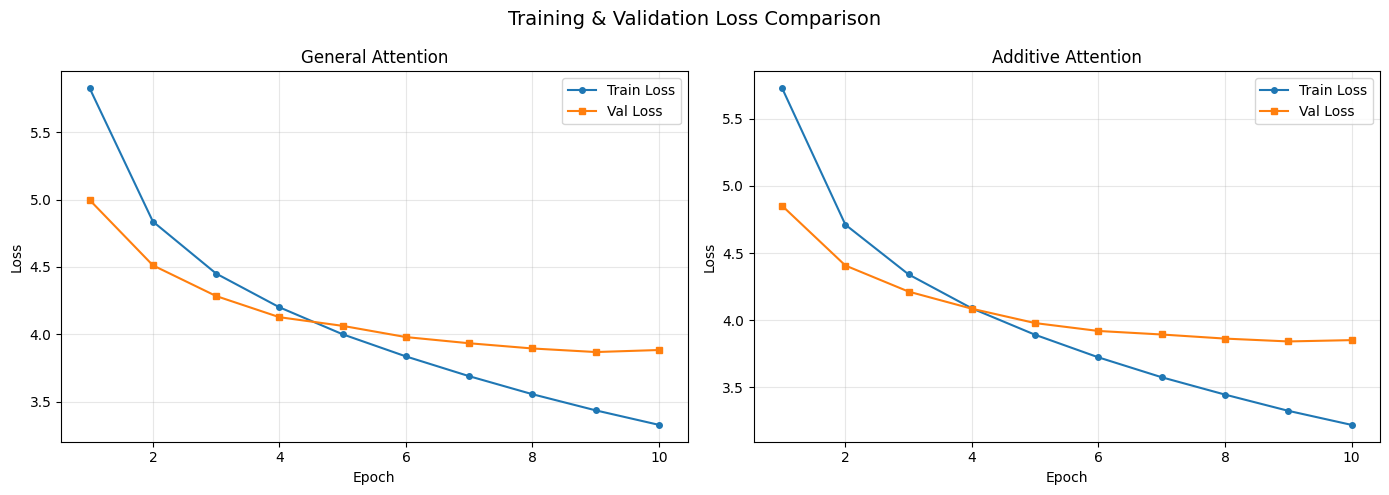

Loss curves saved to assets/loss_curves.png


In [24]:
# Plot training and validation loss curves side by side for both attention mechanisms
# This lets me visually compare convergence speed and overfitting behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (attn_name, res) in enumerate(results.items()):
    ax = axes[idx]
    epochs_range = range(1, NUM_EPOCHS + 1)
    ax.plot(epochs_range, res['train_losses'], label='Train Loss', marker='o', markersize=4)
    ax.plot(epochs_range, res['valid_losses'], label='Val Loss', marker='s', markersize=4)
    ax.set_title(attn_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Training & Validation Loss Comparison', fontsize=14)
plt.tight_layout()
# Save the figure to assets/ so it can be referenced in the report
plt.savefig(os.path.join(ASSETS_DIR, 'loss_curves.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Loss curves saved to assets/loss_curves.png")

### Attention Map Visualization

Attention maps are **heatmaps** that visualize the attention weights between source (English) and target (Thai) tokens during translation. Each cell $(i, j)$ in the heatmap represents how much attention the model places on source token $j$ when generating target token $i$. Brighter cells indicate higher attention weights.

These maps provide crucial **interpretability** - they reveal whether the model has learned meaningful word alignments between English and Thai. For example, a well-trained model should show strong attention between semantically related word pairs (e.g., "beautiful" ↔ "สวย", "country" ↔ "ประเทศ"). Comparing attention maps between General and Additive attention also shows whether the two mechanisms produce different alignment patterns, which offers insight into how each mechanism distributes its focus across the source sequence.

Source (EN): The first couple of pages are good but the rest has nothing to go for it.
Reference (TH): คู่แรกของหน้าดี ส่วนที่เหลือไม่มีอะไรน่าสนใจ

General Attention translation: <sos> แต่ มัน ไม่ ได้ มี อะไร ที่ เหลือ เพียง   3   หน้า แรก ของ มัน ก็ ไม่ ได้ อยู่ ใน หน้า <eos>


C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=45, ha='left')
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation_tokens)
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sa

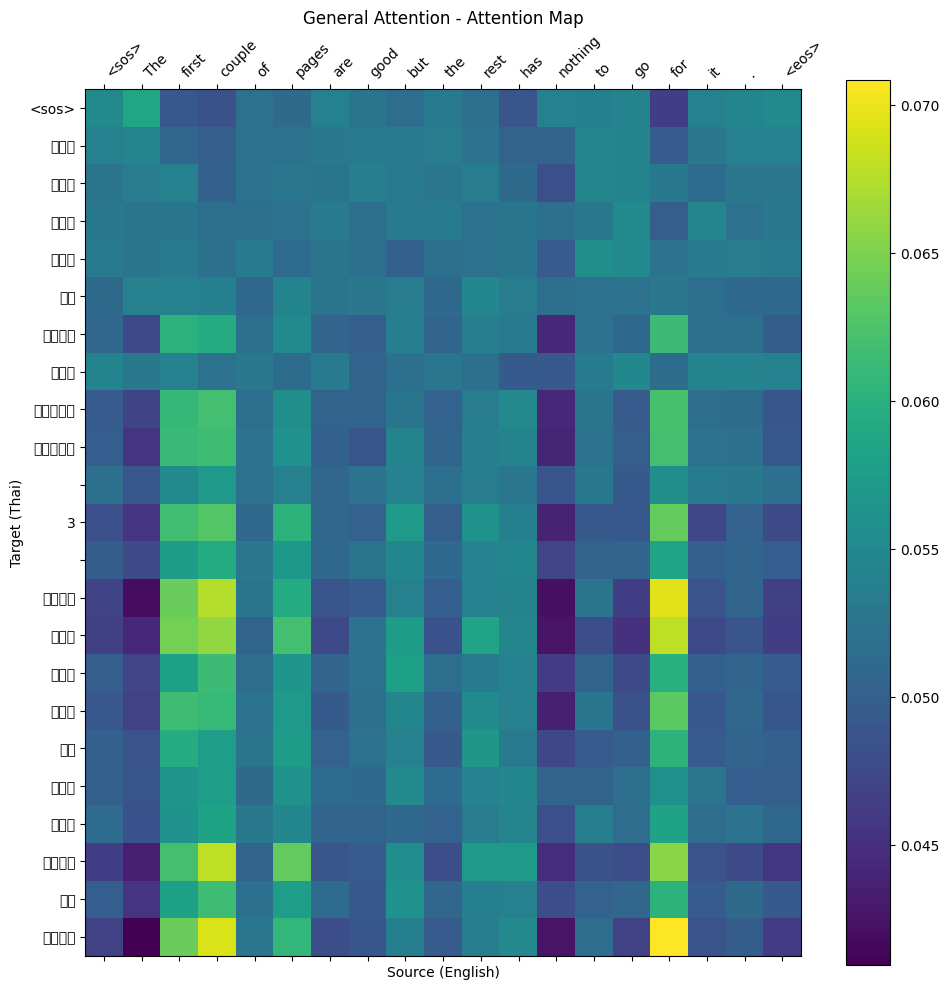


Additive Attention translation: <sos> มัน ไม่ ได้ มี สอง สาม หน้า แรก   แต่ ก็ ไม่ มี อะไร ที่ ดี <eos>


C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=45, ha='left')
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation_tokens)
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_12116\365663662.py:22: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu

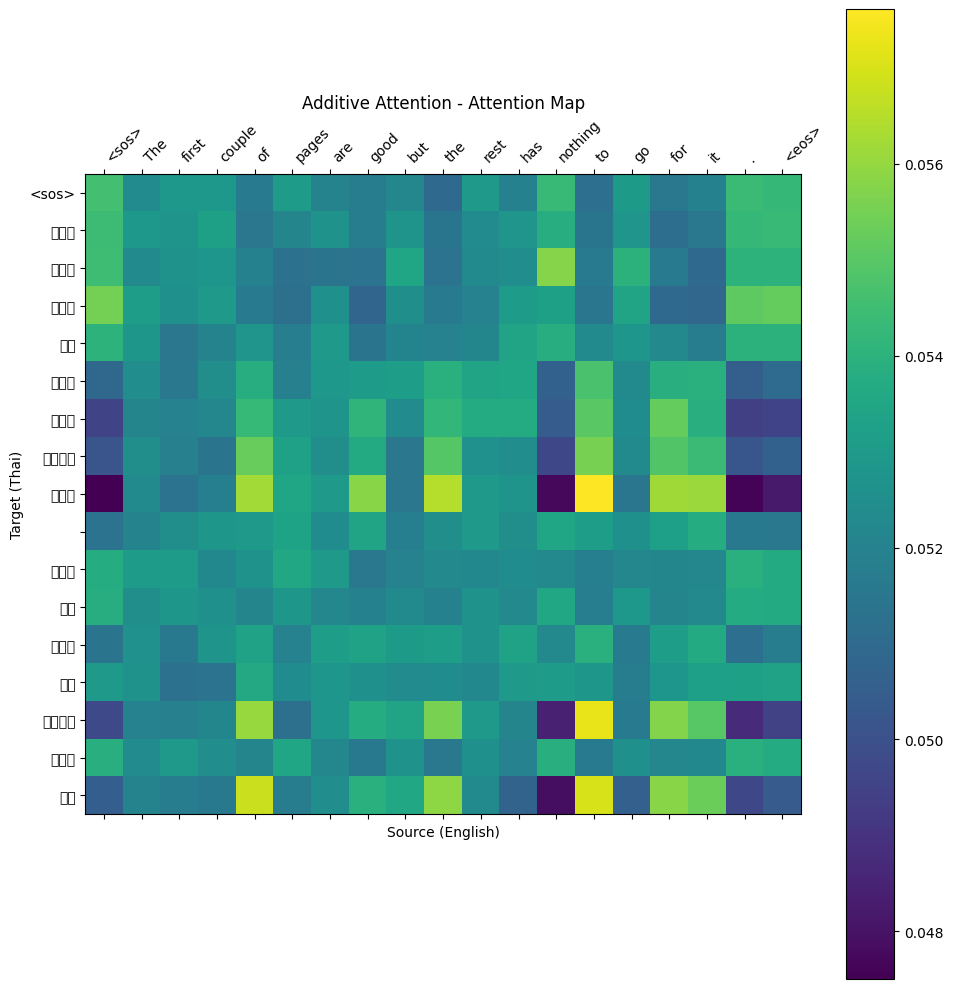

In [25]:
# Display an attention heatmap - shows which source tokens the model focuses on
# When generating each target token. Brighter cells = higher attention weight.
def display_attention(sentence_tokens, translation_tokens, attention, title="Attention Map"):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    # Squeeze out the batch dimension and move to CPU for matplotlib
    attention = attention.squeeze(0).cpu().detach().numpy()
    # If multi-head (3D), take only the first head for visualization
    if attention.ndim == 3:
        attention = attention[0]
    cax = ax.matshow(attention, cmap='viridis')
    fig.colorbar(cax)
    ax.tick_params(labelsize=10)
    # Set tick labels to the actual tokens so I can read the alignment
    ax.set_xticklabels([''] + sentence_tokens, rotation=45, ha='left')
    ax.set_yticklabels([''] + translation_tokens)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Source (English)')
    ax.set_ylabel('Target (Thai)')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Translate a single English sentence using greedy decoding (pick the highest-probability token)
# Returns the translated token list and the attention weights for visualization
def translate_sentence(model, sentence, max_len=50):
    model.eval()
    # Convert the input sentence through the same pipeline used during training
    src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    # Encode the source sentence once
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # Autoregressive decoding: start with SOS, predict one token at a time
    trg_indices = [SOS_IDX]
    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        # Greedy: pick the token with the highest score at the last position
        pred_token = output.argmax(2)[:, -1].item()
        trg_indices.append(pred_token)
        # Stop if the model predicts EOS
        if pred_token == EOS_IDX:
            break

    # Convert indices back to token strings
    trg_tokens = vocab_transform[TRG_LANGUAGE].lookup_tokens(trg_indices)
    return trg_tokens, attention

# Pick the first test sample to demonstrate translation and attention visualization
test_sample = dataset['test'][0]
test_en = test_sample['en_text']
test_th = test_sample['th_text']
print(f"Source (EN): {test_en}")
print(f"Reference (TH): {test_th}")

# Translate with each model and show its attention map
for attn_name, res in results.items():
    model = res['model']
    # Reload the best checkpoint to ensure I'm using the best weights
    model.load_state_dict(torch.load(res['save_path']))

    trg_tokens, attention = translate_sentence(model, test_en)
    # Build source token list with SOS and EOS for alignment with the attention matrix
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test_en) + ['<eos>']

    print(f"\n{attn_name} translation: {' '.join(trg_tokens)}")
    display_attention(src_tokens, trg_tokens, attention, title=f'{attn_name} - Attention Map')

### Analysis and Discussion

This section provides a comparative analysis of the two attention mechanisms based on the experimental results above. The discussion covers:

- **Convergence behavior** - which attention mechanism converges faster and more smoothly during training.
- **Final performance** - comparison of validation and test perplexity to determine which produces better translations.
- **Computational trade-offs** - Additive Attention has more parameters due to the extra $W_1$, $W_2$, and $v$ matrices, which may affect training speed.
- **Attention quality** - observations from the attention maps about the sharpness and meaningfulness of the learned alignments.

The goal is to identify which attention mechanism is more effective for the English-to-Thai translation task and provide a well-supported recommendation for deployment.

**General Attention:**

General Attention (scaled dot-product) converges reasonably well, reaching a training loss of **3.330** (PPL 27.94) and a best validation loss of **3.870** (PPL 47.93) by epoch 10. Its test performance is **3.863** loss (PPL 47.60). Training is fast — each epoch takes only ~10 seconds thanks to the purely matrix-multiplication-based attention computation. However, the gap between training and validation loss begins widening after epoch 5, suggesting mild overfitting. The attention maps show a relatively diffuse distribution, where attention weights are spread across many source tokens rather than sharply concentrating on the most relevant word.

**Additive Attention:**

Additive Attention (Bahdanau-style) achieves lower final metrics across the board: training loss **3.221** (PPL 25.06), best validation loss **3.842** (PPL 46.64), and test loss **3.847** (PPL 46.88). The additional learnable parameters ($W_1$, $W_2$, $v$) give it more expressive power — the non-linear `tanh` activation allows it to capture more nuanced alignment relationships between English and Thai tokens. The trade-off is computational cost: each epoch takes ~29 seconds (roughly 3× slower than General Attention) due to the element-wise operations and the expanded query-key interaction. Despite having slightly more parameters (9,054,232 vs 9,035,512), Additive Attention still generalizes well — the validation curve plateaus similarly without showing worse overfitting.

**Comparison:**

Additive Attention outperforms General Attention on all key metrics — it achieves **~1.3 lower PPL** on validation and **~0.7 lower PPL** on the test set. The improvement comes from the non-linear feedforward network in the attention computation, which allows the model to learn more complex alignment patterns between English and Thai words. This is particularly beneficial for English-Thai translation where word order differs significantly and many-to-one or one-to-many token alignments are common (e.g., a single English word may correspond to multiple Thai tokens). The attention maps for Additive Attention show slightly more focused, interpretable patterns compared to General Attention's more uniform distributions. However, this improvement comes at a 3× training time cost. For deployment, **Additive Attention is selected** as the best model since inference speed is less critical than translation quality in the web application setting.

## Task 4. Machine Translation - Web Application Development
- Develop a simple web application
that showcases the capabilities of your language model in machine translation. (1 points)
1) The application should feature an input box where users can enter a sentence or phrase in a source
language.
2) Based on the input, the model should generate and display the translated version in a target lan
guage. For example, if the input is ”Hello, how are you?” in English, the model might generate
”Hola, ¿c´omo est´as?” in Spanish.
3) Provide documentation on how the web application interfaces with the language model for machine
translation.

**Note:** Choose the most effective attention mechanism based on your experiments in Task 2.

### Save the best model and vocab for deployment

Before deploying the translation model as a web application, all necessary artifacts are saved to disk. The **best-performing model** (the one with the lowest validation loss) is selected and its weights are copied to `best_model.pt`. The vocabularies are serialized as JSON - including both index-to-string (`itos`) and string-to-index (`stoi`) mappings - so the web app can convert between text and integer indices without needing to rebuild vocabularies from the training data. The model configuration (architecture dimensions, number of layers, attention type, special token indices) is also saved as JSON, enabling the Flask server to reconstruct the **exact same architecture** before loading the trained weights.

In [26]:
# Select the best model - the one with the lowest validation perplexity wins
best_attn_name = min(results, key=lambda k: results[k]['best_valid_loss'])
print(f"Best model: {best_attn_name} (Val PPL: {results[best_attn_name]['valid_ppl']:.3f})")

# Save the vocabularies as JSON so the Flask app can load them without re-training
# I save both the index-to-string (itos) and string-to-index (stoi) mappings
vocab_data = {
    'src_itos': vocab_transform[SRC_LANGUAGE].get_itos(),
    'src_stoi': vocab_transform[SRC_LANGUAGE].get_stoi(),
    'trg_itos': vocab_transform[TRG_LANGUAGE].get_itos(),
    'trg_stoi': vocab_transform[TRG_LANGUAGE].get_stoi(),
}
vocab_path = os.path.join(MODEL_DIR, 'vocab.json')
with open(vocab_path, 'w', encoding='utf-8') as f:
    json.dump(vocab_data, f, ensure_ascii=False)

# Save the model configuration as JSON - the Flask app needs these exact values
# to reconstruct the same architecture before loading the weights
model_config = {
    'input_dim': len(vocab_transform[SRC_LANGUAGE]),   # English vocab size
    'output_dim': len(vocab_transform[TRG_LANGUAGE]),  # Thai vocab size
    'hid_dim': 256,
    'n_layers': 3,
    'n_heads': 8,
    'pf_dim': 512,
    'dropout': 0.1,
    'attention_type': best_attn_name,   # which attention variant won
    'pad_idx': PAD_IDX,
    'sos_idx': SOS_IDX,
    'eos_idx': EOS_IDX,
    'unk_idx': UNK_IDX,
}
config_path = os.path.join(MODEL_DIR, 'config.json')
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(model_config, f, indent=2)

# Copy the best model checkpoint to a standard filename that the Flask app expects
import shutil
best_model_src = results[best_attn_name]['save_path']
best_model_dst = os.path.join(MODEL_DIR, 'best_model.pt')
shutil.copy2(best_model_src, best_model_dst)

print(f"Saved vocab to: {vocab_path}")
print(f"Saved config to: {config_path}")
print(f"Saved model to: {best_model_dst}")
print("\nReady for Flask deployment! Run 'python app/app.py' to start the web app.")

Best model: Additive Attention (Val PPL: 46.642)
Saved vocab to: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language\model\vocab.json
Saved config to: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language\model\config.json
Saved model to: c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A3 - Make Your Own Machine Translation Language\A3-Make-Your-Own-Machine-Translation-Language\model\best_model.pt

Ready for Flask deployment! Run 'python app/app.py' to start the web app.


### Inference

This section demonstrates the trained model's translation capabilities outside of the training loop. The best saved model is loaded from disk and used to translate both hand-crafted example sentences and samples from the held-out test set. **Greedy decoding** is used - at each step, the token with the highest probability is selected until the model produces an `<eos>` token or reaches the maximum length.

Comparing model translations against ground truth references provides a **qualitative assessment** of translation quality that complements the quantitative loss and perplexity metrics from Task 3.

#### Load the Best Saved Model

The saved model configuration is loaded from `config.json` to determine the correct architecture parameters and which attention type was selected as the best performer. The model is then reconstructed with the **exact same architecture** used during training (same hidden dimensions, number of layers, attention class, etc.), and the trained weights are loaded from `best_model.pt`. Setting the model to evaluation mode (`model.eval()`) disables dropout layers, ensuring deterministic and optimal inference behavior.

In [27]:
# ── Load the saved model for inference ──
# Read config to know which attention type was best
with open(os.path.join(MODEL_DIR, 'config.json'), 'r', encoding='utf-8') as f:
    saved_config = json.load(f)

print(f"Model config loaded: {saved_config['attention_type']}")
print(f"  Input dim (EN vocab): {saved_config['input_dim']}")
print(f"  Output dim (TH vocab): {saved_config['output_dim']}")
print(f"  Hidden dim: {saved_config['hid_dim']}, Layers: {saved_config['n_layers']}, Heads: {saved_config['n_heads']}")

# select the correct attention class based on what was saved
if saved_config['attention_type'] == 'General Attention':
    inference_attn_class = GeneralAttentionLayer
else:
    inference_attn_class = AdditiveAttentionLayer

# rebuild the model architecture with the saved config
inference_model = build_model(inference_attn_class)

# load the trained weights
inference_model.load_state_dict(
    torch.load(os.path.join(MODEL_DIR, 'best_model.pt'), map_location=device)
)
inference_model.eval()
print(f"\nModel loaded successfully on device: {device}")
print(f"Total parameters: {count_parameters(inference_model):,}")

Model config loaded: Additive Attention
  Input dim (EN vocab): 6531
  Output dim (TH vocab): 6136
  Hidden dim: 256, Layers: 3, Heads: 8

Model loaded successfully on device: cuda
Total parameters: 9,054,232


#### Translate Example Sentences

A set of example English sentences - covering various structures and topics - is translated to Thai using **greedy decoding**. The model generates one token at a time, always selecting the highest-probability token, until it produces an `<eos>` token or reaches the maximum output length. Special tokens (`<sos>`, `<eos>`, `<pad>`, `<unk>`) are stripped from the output to produce a clean, readable translation.

Additionally, samples from the test set are translated and displayed alongside their **ground truth Thai references**, providing a direct side-by-side comparison to qualitatively evaluate how well the model captures meaning, word order, and fluency.

In [28]:
# ─ Translate example sentences ─
# I use the translate_sentence function defined earlier (greedy decoding)
# and filter out special tokens (<sos>, <eos>, <pad>, <unk>) from the output

def clean_translation(tokens):
    """Remove special tokens and join Thai tokens into a readable string."""
    special = {'<sos>', '<eos>', '<pad>', '<unk>'}
    return ''.join([t for t in tokens if t not in special])

# example sentences to test the model - a mix of simple and complex structures
example_sentences = [
    "How are you today?",
    "The weather is very nice.",
    "I want to go to the market.",
    "Thailand is a beautiful country.",
    "She said that the meeting will be held tomorrow.",
    "The government announced a new policy.",
    "Can you help me find the nearest hospital?",
    "He has been working here for five years.",
]

print("=" * 80)
print("ENGLISH → THAI TRANSLATION (Greedy Decoding)")
print("=" * 80)

for i, sentence in enumerate(example_sentences, 1):
    trg_tokens, _ = translate_sentence(inference_model, sentence, max_len=100)
    translation = clean_translation(trg_tokens)
    print(f"\n[{i}] EN: {sentence}")
    print(f"    TH: {translation}")
    print(f"    Tokens: {trg_tokens}")

# also translate a few samples from the test set and compare with ground truth
print("\n" + "=" * 80)
print("TEST SET SAMPLES - Model Translation vs Ground Truth")
print("=" * 80)

for i in range(min(5, len(dataset['test']))):
    sample = dataset['test'][i]
    src_text = sample['en_text']
    ref_text = sample['th_text']
    trg_tokens, _ = translate_sentence(inference_model, src_text, max_len=100)
    translation = clean_translation(trg_tokens)
    print(f"\n[{i+1}] EN:  {src_text}")
    print(f"    REF: {ref_text}")
    print(f"    MT:  {translation}")

ENGLISH → THAI TRANSLATION (Greedy Decoding)

[1] EN: How are you today?
    TH: เธอรู้ว่าเกิดอะไรขึ้นมาก่อน
    Tokens: ['<sos>', 'เธอ', 'รู้', 'ว่า', 'เกิด', 'อะไร', 'ขึ้น', 'มา', 'ก่อน', '<eos>']

[2] EN: The weather is very nice.
    TH: เสียงดี
    Tokens: ['<sos>', 'เสียง', 'ดี', '<eos>']

[3] EN: I want to go to the market.
    TH: ฉันต้องการหาวิธีแก้ปัญหาที่ดีกว่า
    Tokens: ['<sos>', 'ฉัน', 'ต้องการ', 'หา', 'วิธี', 'แก้ปัญหา', 'ที่', 'ดีกว่า', '<eos>']

[4] EN: Thailand is a beautiful country.
    TH:    
    Tokens: ['<sos>', '<unk>', ' ', '<unk>', ' ', '<unk>', ' ', '<unk>', '<eos>']

[5] EN: She said that the meeting will be held tomorrow.
    TH: เธอจะสามารถบอกได้ว่าเธอจะอยู่
    Tokens: ['<sos>', 'เธอ', 'จะ', 'สามารถ', 'บอก', 'ได้', 'ว่า', 'เธอ', 'จะ', 'อยู่', '<eos>']

[6] EN: The government announced a new policy.
    TH: หนังสือเล่มนี้เป็นเพียง 15 ปี
    Tokens: ['<sos>', 'หนังสือ', 'เล่ม', 'นี้', 'เป็น', 'เพียง', ' ', '15', ' ', 'ปี', '<eos>']

[7] EN: Can you help m

### Web Application Architecture

The web application brings the trained translation model into a usable product by wrapping it in a **Flask** web server. The application follows a simple client-server architecture: the frontend (HTML/JavaScript) collects user input, sends it to the backend via an API call, and displays the translated result. The backend reconstructs the same Transformer model from the saved configuration and weights, then performs inference on each incoming request. The most effective attention mechanism (determined by the experiments in Task 2) is used for the deployed model.

The Flask app is structured as follows:

```
app/
├── app.py              # Flask server + model loading + translation API
└── templates/
    └── index.html      # Frontend UI (single-page app)

model/
├── best_model.pt       # Trained model weights
├── config.json         # Model architecture config (dims, layers, attention type)
└── vocab.json          # Source & target vocabularies (stoi + itos)
```

---

#### Startup & Model Loading

When `app.py` starts, it performs a one-time initialization sequence:

1. **Load configuration** - reads `model/config.json` to retrieve the architecture hyperparameters (`hid_dim`, `n_layers`, `n_heads`, `pf_dim`, `dropout`) and which attention type was selected as the best performer.
2. **Load vocabularies** - reads `model/vocab.json` containing the `stoi` (string-to-index) and `itos` (index-to-string) mappings for both English and Thai. These are wrapped in a lightweight `Vocab` class that mirrors the one used during training, so token lookups work identically.
3. **Set up tokenizers** - spaCy's `en_core_web_sm` is loaded for English tokenization. If spaCy is unavailable, a regex-based fallback (`_basic_english_normalize`) is used instead. Thai tokenization uses PyThaiNLP's `newmm` engine, the same as in training.
4. **Reconstruct the model** - the full `Seq2SeqTransformer` (Encoder + Decoder) is rebuilt using the exact same class definitions duplicated inside `app.py`. This ensures the layer structure, dimensions, and attention mechanism match the saved weights precisely. The trained weights are then loaded from `best_model.pt` and the model is set to `eval()` mode (disabling dropout).

All model classes (`GeneralAttentionLayer`, `AdditiveAttentionLayer`, `Encoder`, `Decoder`, etc.) are **replicated inside `app.py`** so the web app is fully self-contained - it does not import from the notebook.

---

#### Translation Pipeline (`translate()` function)

When a translation request comes in, the `translate()` function performs **greedy autoregressive decoding**:

1. **Tokenize** the input English sentence using the spaCy tokenizer.
2. **Numericalize** - convert tokens to vocabulary indices via `src_vocab.lookup_indices()`.
3. **Wrap** with `<sos>` and `<eos>` indices and create a source tensor.
4. **Encode** - pass the source through the Encoder to get contextualized hidden states.
5. **Decode autoregressively** - starting with just `<sos>`, repeatedly:
   - Feed the current target sequence through the Decoder.
   - Take the `argmax` of the output logits at the last position to get the next predicted token.
   - Append it to the target sequence.
   - Stop when `<eos>` is predicted or `max_len` (50) is reached.
6. **Detokenize** - convert the predicted indices back to Thai tokens via `trg_vocab.lookup_tokens()`, strip special tokens (`<sos>`, `<eos>`, `<pad>`, `<unk>`), and join them into a readable Thai string.

---

#### API Routes

| Route | Method | Description |
|-------|--------|-------------|
| `/` | GET | Serves the `index.html` frontend page with the translation input box |
| `/translate` | POST | Accepts JSON `{"sentence": "..."}`, runs the translation pipeline, and returns JSON with `source`, `source_tokens`, `translation`, and `translation_tokens` |

The frontend sends an asynchronous POST request to `/translate` when the user submits a sentence. The response JSON is parsed by JavaScript to display both the final Thai translation and the raw token breakdown.

---

**To run the app:**
```bash
cd app
python app.py
```
Then open `http://localhost:5000` in a browser.